In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import scipy.io as sio
import networkx as nx

from matplotlib import pyplot as plt

from helpers import signed_laplacian, signed_layout, get_borderless_fig, draw_edges, pos_spring_layout
from core import query_graph_using_sparse_linear_solver, sweep_on_x

In [3]:
# pre-process graph
if not os.path.exists('data/word_graph.pkl'):
    mat_contents = sio.loadmat('data/word_sim_weighted.mat')

    A = mat_contents['Wemb']
    names = mat_contents['names']
    i2w = {i: names[i][0][0] for i in range(A.shape[0])}
    w2i = {w: i for i, w in i2w.items()}

    g = nx.from_scipy_sparse_matrix(A, edge_attribute='sign')

    gc = max(nx.connected_component_subgraphs(g), key=len)
    mapping = {n: i for i, n in enumerate(gc.nodes())}
    w2i_new = {i2w[old]: new for old, new in mapping.items()}
    i2w_new = {new: i2w[old] for old, new in mapping.items()}

    gc = nx.relabel_nodes(gc, mapping=mapping)
    w2i = w2i_new
    i2w = i2w_new
    del g
    gc.graph['w2i'] = w2i
    gc.graph['i2w'] = i2w
    nx.write_gpickle(gc, 'data/word_graph.pkl')
else:
    # load pre-processed graph
    g = nx.read_gpickle('data/word_graph.pkl')
    w2i = g.graph['w2i']
    i2w = g.graph['i2w']    

In [22]:
print('graph dimension:', g.number_of_nodes(), g.number_of_edges())

graph dimension: 4962 47088


In [4]:
def pos_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] > 0]

def neg_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] < 0]

print(' '.join(pos_nbrs(g, 'happy')))
print(' '.join(neg_nbrs(g, 'happy')))

light content meet fit fitting cheerful successful jolly good nice proper glad accidental right promising upbeat ready well willing incidental sparkling smiling
poor melancholic down blue serious dark ashamed downcast boiling disagreeable upset unhappy heavy sad unfortunate


In [5]:
def demo(word1, word2=None, kappa=0.5):
    seeds = [[w2i[word1]]]
    if word2 is not None:
        seeds.append([w2i[word2]])

    x_opt, opt_val = query_graph_using_sparse_linear_solver(g, seeds, kappa=kappa, solver='cg', verbose=1)
    c1, c2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x(g, x_opt, top_k=200, verbose=1)

    fig, ax = plt.subplots(1, 1)
    ax.plot(ts, sbr_list, '.-')
    ax.axvline(best_t, color='red')         
    ax.set_title('sweeping profile')
    
    c1_words = [i2w[n] for n in c1]
    c2_words = [i2w[n] for n in c2]
    print('community 1 has {} nodes\nthey are:'.format(len(c1)))
    print(' '.join(c1_words))
    print()
    print('community 1 has {} nodes\nthey are:'.format(len(c2)))
    print(' '.join(c2_words))

    try:
        subg = g.subgraph(C)

        subg = nx.convert_node_labels_to_integers(subg)
        
        pos = pos_spring_layout(subg)

        fig, ax = get_borderless_fig()
        # draw_nodes(subg, pos, ax=ax)
        nx.draw_networkx_nodes(subg, pos, node_size=2, linewidths=0, node_color='black')
        draw_edges(subg, pos, ax=ax, width=0.5, alpha=0.5)        
    except:
        print('unable to plot')
        pass
    return c1_words, c2_words, dict(x_opt=x_opt)

matrices loading done
found lambda_1= (0.029549341418421048+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.10534946054184291
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.10529420457607708


  0%|          | 0/200 [00:00<?, ?it/s]

at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.06817794070965821
at iteration 20 (alpha=-1.49728)
residual: sqrt(kappa) - y' D s=-0.007096195800478933
terminates after 22 iterations:
  - alpha=-1.42992
  - residual=-0.00051
sweep on top 200


100%|██████████| 200/200 [00:33<00:00,  6.21it/s]


best_t: 0.00369015673555299
comm1: [ 351  360  423  424  881 1132 1133 1794 1864 2007 2314 2670 3007 3773
 4001 4072 4282 4501 4605 4702 4797]
comm2: [  18   30  166  346  705 1517 1597 1774 2067 3326 3385 3818 3823 3954
 3974 4100 4183 4368 4569 4828 4902 4932 4942]
community 1 has 21 nodes
they are:
blue boiling broiling brunette defeatist downbeat downcast hurting impromptu insurgent melancholic penitent repellent unfortunate worrying ashamed dreary navy sad unhappy disagreeable

community 1 has 23 nodes
they are:
absorbent accidental antiseptic blonde content freezing glad hopeful jolly smiling sparkling upbeat uplifting well willing beautiful cheerful happy proud freely promising skillfully sweetened


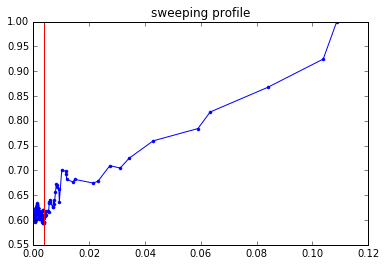

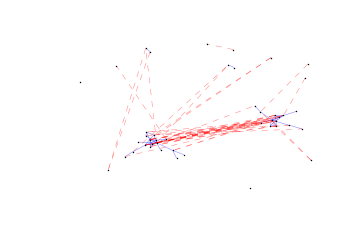

In [6]:
exp1_c1, exp1_c2, exp1 = demo('happy', 'unhappy', kappa=0.8)

In [7]:
def set_comp(s1, s2):
    s1, s2 = set(s1), set(s2)
    print('s1 - s2:', ', '.join(s1 - s2))
    print('s2 - s1:', ', '.join(s2 - s1))
    print('s2 AND s1:', ', '.join(s1.intersection(s2)))
    
def rank_of_word(scores, word):
    order = np.argsort(scores)
    return (order == w2i[word]).nonzero()[0][0]


In [8]:
print('rank of "happy"', rank_of_word(exp1['x_opt'], 'happy'))
print('rank of "unhappy"', rank_of_word(exp1['x_opt'], 'unhappy'))
print('max rank', g.number_of_nodes() - 1)

rank of "happy" 4961
rank of "unhappy" 0
max rank 4961


In [9]:
print('set difference with positive nbrs:\n')
set_comp(exp1_c2, pos_nbrs(g, 'happy'))
print('-' * 10)
set_comp(exp1_c1, pos_nbrs(g, 'unhappy'))

set difference with positive nbrs:

s1 - s2: happy, antiseptic, beautiful, freely, uplifting, blonde, proud, sweetened, freezing, absorbent, skillfully, hopeful
s2 - s1: nice, ready, proper, right, successful, light, incidental, good, fitting, meet, fit
s2 AND s1: jolly, glad, smiling, promising, upbeat, well, sparkling, accidental, cheerful, willing, content
----------
s1 - s2: penitent, impromptu, ashamed, insurgent, worrying, brunette, disagreeable, boiling, unhappy, broiling, defeatist, navy
s2 - s1: forbidding, bad, tart, hurt, poor, wrong, dark, melancholy, rough, acid, low, sharp, harsh, caustic, down, sore, bitter
s2 AND s1: unfortunate, sad, downcast, blue, melancholic, hurting, dreary, downbeat, repellent


matrices loading done
found lambda_1= (0.029549341418421228+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.2926698703552112
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.29261461438944536
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.2554983505230265
at iteration 20 (alpha=-0.77877)
residual: sqrt(kappa) - y' D s=0.00033365665640017195
at iteration 25 (alpha=-0.78158)
residual: sqrt(kappa) - y' D s=-0.028630185128968866


  0%|          | 0/200 [00:00<?, ?it/s]

at iteration 30 (alpha=-0.77886)
residual: sqrt(kappa) - y' D s=-0.0011798897008955533
terminates after 31 iterations:
  - alpha=-0.77881
  - residual=-0.00043
sweep on top 200


100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


best_t: 0.14092167488479465
comm1: [2193]
comm2: [1815]
community 1 has 1 nodes
they are:
literate

community 1 has 1 nodes
they are:
illiterate


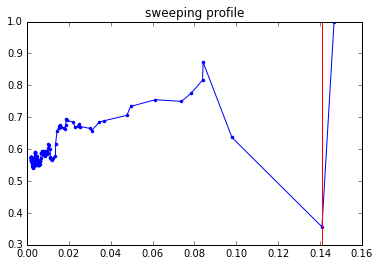

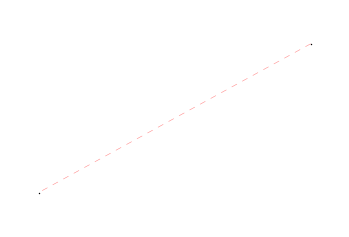

In [10]:
_, _, exp2 = demo('happy', 'unhappy', kappa=0.5)

In [23]:
order = np.argsort(exp2['x_opt'])
print('first and last word by x_opt: ', i2w[order[0]], i2w[order[-1]])
exp2['x_opt']
print('indices of "happy" and "unhappy" by x_opt: ',
      (order == w2i['happy']).nonzero()[0][0],
      (order == w2i['unhappy']).nonzero()[0][0]
)
print('max index {}'.format(g.number_of_nodes()-1))


first and last word by x_opt:  literate illiterate
indices of "happy" and "unhappy" by x_opt:  4960 2
max index 4961


matrices loading done
found lambda_1= (0.029549341418420937+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.29289313737209244
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.2928100202993166
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.24244410662472948
at iteration 20 (alpha=-0.77877)
residual: sqrt(kappa) - y' D s=0.09457207762470499
at iteration 25 (alpha=-0.78719)
residual: sqrt(kappa) - y' D s=-0.004967622785156833


  0%|          | 1/200 [00:00<00:33,  5.95it/s]

terminates after 28 iterations:
  - alpha=-0.78614
  - residual=-0.00087
sweep on top 200


100%|██████████| 200/200 [00:32<00:00,  6.31it/s]


best_t: 0.002885074766726897
comm1: [  59  267  290  293  351  355  360  423  424  653  830  879  881 1024
 1130 1131 1132 1133 1136 1141 1185 1542 1655 1794 1858 1864 1999 2099
 2193 2234 2289 2314 2315 2382 2456 2457 2458 2670 2754 2769 3098 3151
 3516 3581 3719 3762 3773 4001 4072 4136 4282 4306 4361 4383 4501 4605
 4657 4700 4702 4713 4779 4797 4827 4847 4855 4862 4888 4928 4952]
comm2: [  11   18   30   94   95  166  208  346  427  478  705  768  837  838
  840  842  858 1015 1197 1204 1416 1517 1597 1657 1774 1815 1818 1953
 2067 2228 2609 2611 2634 2636 2744 2763 2818 2984 3089 3325 3326 3346
 3367 3385 3519 3818 3821 3823 3954 3962 3974 4082 4153 4177 4181 4183
 4368 4424 4487 4569 4743 4793 4808 4823 4828 4902 4918 4932 4938 4942]
community 1 has 69 nodes
they are:
ad-lib baking bass bawdy blue blush boiling broiling brunette concomitant dark defeated defeatist discomfited down down-and-out downbeat downcast downhill drab dusk frown grimace hurting impossible impromptu insomni

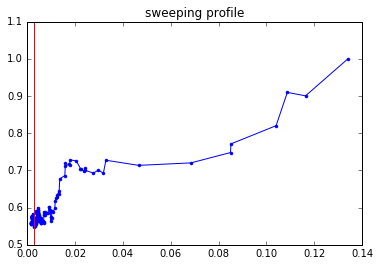

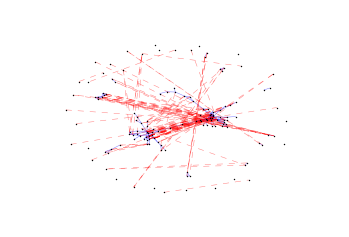

In [12]:
exp3_c1, exp3_c2, exp3 = demo('happy', kappa=0.5)

In [13]:
print('rank of "happy"', rank_of_word(exp3['x_opt'], 'happy'))
print('rank of "unhappy"', rank_of_word(exp3['x_opt'], 'unhappy'))

rank of "happy" 4961
rank of "unhappy" 11


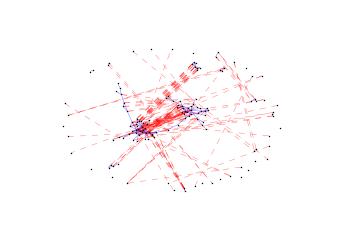

In [14]:
C = list(sorted([w2i[w] for w in (exp3_c1 + exp3_c2)]))
old2new = {n: i for i, n in enumerate(C)}
new2old = {i: n for i, n in enumerate(C)}
subg = nx.relabel_nodes(g.subgraph(C), mapping=old2new)
# pos = signed_layout(subg, normalize=True)
pos = pos_spring_layout(subg)

fig, ax = get_borderless_fig()
# draw_nodes(subg, pos, ax=ax)
nx.draw_networkx_nodes(subg, pos, node_size=2, linewidths=0, node_color='black')
draw_edges(subg, pos, ax=ax, width=0.5, alpha=0.5)

In [15]:
from spectral import signed_spectral_clustering
from collections import defaultdict

labels = signed_spectral_clustering(subg, k=10, normalize=True)
w2label = {i2w[new2old[i]]: l for i, l in enumerate(labels)}

clustering = defaultdict(list)
for w, l in w2label.items():
    clustering[l].append(w)
print('clustering result (k=10):')
for words in clustering.values():
    print('-' * 10)
    print(', '.join(words))

clustering result (k=10):
----------
antiseptic, forgotten, daybreak, entertaining, content, sociable, illumination, possible, affluent, inevitable, cheerful, glad, happy, freezing, above, lowbrow, cracking, willing, skillfully, day, freely, promising, plush, deftly, upbeat, rejoicing, charcoal, jet, uphill, jolly, pastel, smiling, afternoon, blonde, morning, bubbly, cavalier, sparkling, hopeful, candidate, probable, champagne, decadent, sunup, proud, uplifting, fitting, successful, ascending, daytime, daylight, feasible, well, pasty, roaring
----------
knowing, sad, masculine, melancholic, dark, drab, dreary, nighttime, tumbling, sundown, concomitant, down, night, insomniac, blue, serious, defeatist, honey, sweetened, navy, ashamed, baking, downcast, undesirable, judged, down-and-out, consumed, straw, accentuate, lowered, brunette, nightfall, lumbering, unfortunate, imposed, bawdy, remembered, dusk, unlikely, disarming, guilty, boiling, moody, downbeat, broiling, tantrums, literate, i

/home/cloud-user/code/signed/helpers.py:363: RuntimeWarning: divide by zero encountered in true_divide
  D_neg_half = sp.diags(flatten(1 / np.sqrt(deg)))


# observation


- "irrelevant" communities (that are connected to the main one by negative edges) can be returned, which is less meaningful
  - a reasonable post-processing step: remove nodes that are solely connected by negative edges (or do a BFS on the positive graph)
- if $\kappa$ is set too low (e.g, 0.5), seeds will not rank top and sweeping result might not include the seeds
  - this implies that a good $\kappa$ should ensure seeds are included in the sweeping result or they rank high in `x_opt`
- however, if $\kappa$ set high enough (0.8 for example), seeds are included


# speed comparison ("cg" vs "sp")

In [16]:
%timeit -n1 -r1 query_graph_using_sparse_linear_solver(g, [[w2i['happy']], [w2i['unhappy']]], kappa=0.8, solver='cg', verbose=1)


matrices loading done
found lambda_1= (0.02954934141842104+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.10534946054184291
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.10529420457607708
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.06817794070965821
at iteration 20 (alpha=-1.49728)
residual: sqrt(kappa) - y' D s=-0.007096195800478933
terminates after 22 iterations:
  - alpha=-1.42992
  - residual=-0.00051
816 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
%timeit -n1 -r1 query_graph_using_sparse_linear_solver(g, [[w2i['happy']], [w2i['unhappy']]], kappa=0.8, solver='sp', verbose=1)

matrices loading done
found lambda_1= (0.02954934141842116+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.10534945950146324
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.10529420429600755
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.06817775652856628
at iteration 20 (alpha=-1.49728)
residual: sqrt(kappa) - y' D s=-0.007096183642422704
terminates after 22 iterations:
  - alpha=-1.42992
  - residual=-0.00051
3min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
print('speedup ratio', 3.5 * 60 * 1000 / 816)


speedup ratio 257.3529411764706
